# **\[SOLAR_A\]** LRGCN (+ 수정 및 시뮬레이션)

JiyunLim  
2023-08-28

**2023.08.28 update** :

-   에폭을 30으로 설정하고 학습을 진행하면 과대적합 되는 것 같음.
    (연습때는 10에폭 이내로 빠르게 멈췄는데 시뮬레이션 시 30에폭까지
    가는 경우도 있었음..)

-   배치들의 평균 로스가 줄어드는 것과 실제값과 예측값의 평균 로스가
    줄어드는 것과는 차이가 있는 것 같다. (배치평균 로스기준으로
    얼리스타핑 적용시켜놨는데 배치평균로스가 줄어도 MSE값은 올라가는
    경우 발생.)

-   **진행중** : 10에폭으로 설정하고 시뮬레이션 다시 진행. (lag=24,
    lr=0.01)

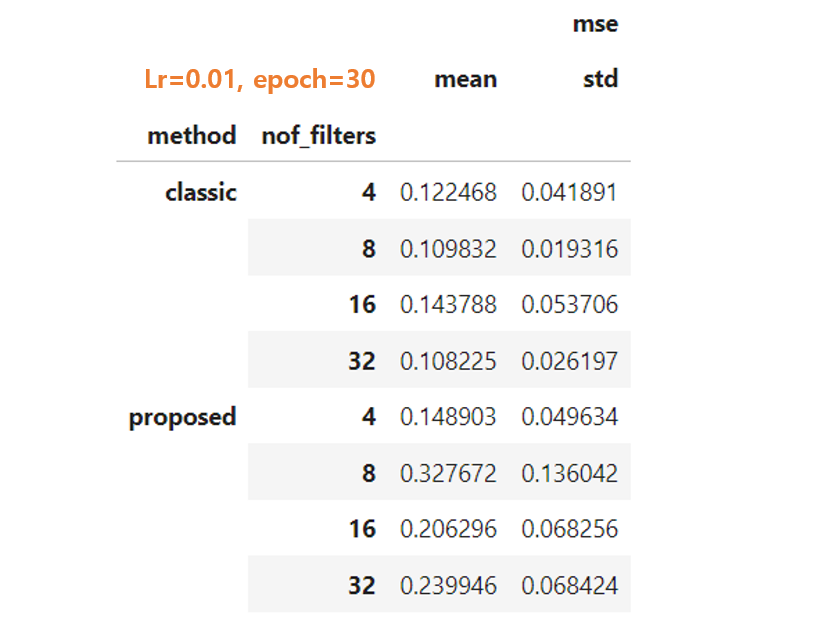

# 2023.08.15 러너 수정

> **변경사항**: RGCN_Learner 수정 – 일부기능추가

> **포인트**: 배치학습을 적용하여 update가 빨리이루어지도록 코드수정

## Import

-   lag=24

In [1]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric temporal
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import LRGCN

# torch
import torch
import torch.nn.functional as F

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        edge_weights = np.array(self._dataset["weights"]).T
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = eptstgcn.utils.temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    # yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 
    

def rslt_plot(y, yhat, t_, node_idx):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={lrnr.epochs}, node_idx={node_idx}',size=15)
            ax.legend()

In [2]:
class LR_GCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(LR_GCN, self).__init__()
        self.recurrent = LRGCN(node_features, filters, 1, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

## Load data

In [5]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [6]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample codes

`-` y를 학습

In [11]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 8
lrnr.model = LR_GCN(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.61449040273247771020813             
epoch=2  loss=0.128079366415392535285492            
epoch=3  loss=0.104814620775192285012054            
epoch=4  loss=0.096958694892913844984436            
epoch=5  loss=0.094150934758227932110977        

In [36]:
for e in range(5):
    lrnr.learn()
    
for e in range(5):
    lrnr1.learn()
    
for e in range(5):
    lrnr2.learn()

epoch=6  loss=0.094050379426673493969727            
epoch=7  loss=0.093022370451065226331711            
epoch=8  loss=0.092045960947871210637741            
epoch=9  loss=0.091289407985154975134201            
epoch=10     loss=0.09074097915097724555939         
epoch=6  loss=0.015654810319849572442524            
epoch=7  loss=0.01217930529504841510108             
epoch=8  loss=0.0093507244722744411618252       
epoch=9  loss=0.0078485326511178948153992       
epoch=10     loss=0.00680537204268973259952         
epoch=6  loss=0.0120661317988103983580208       
epoch=7  loss=0.011973789597991423762493            
epoch=8  loss=0.0118896708807496481633148       
epoch=9  loss=0.01184580874152828005188 6       
epoch=10     loss=0.011784907866291008661232        

In [12]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [13]:
np.mean((y - yhat)**2)

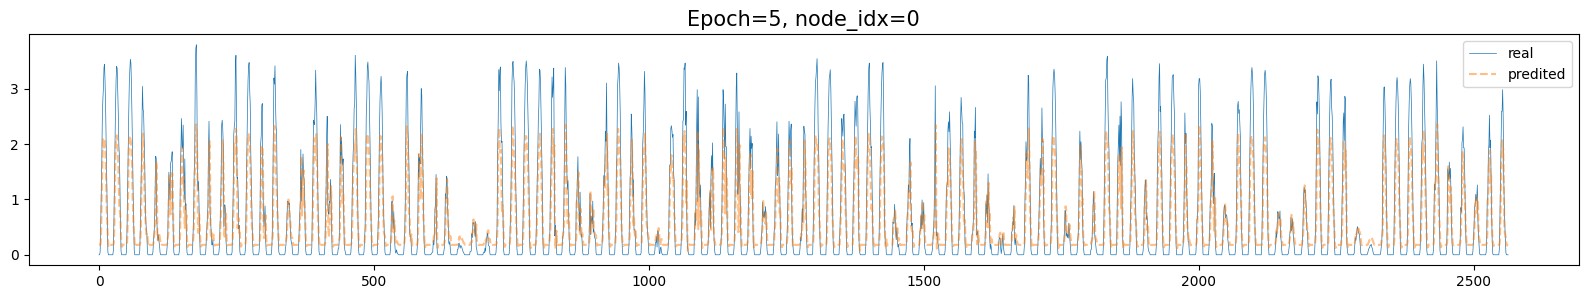

In [14]:
lrnr.figs[-1]

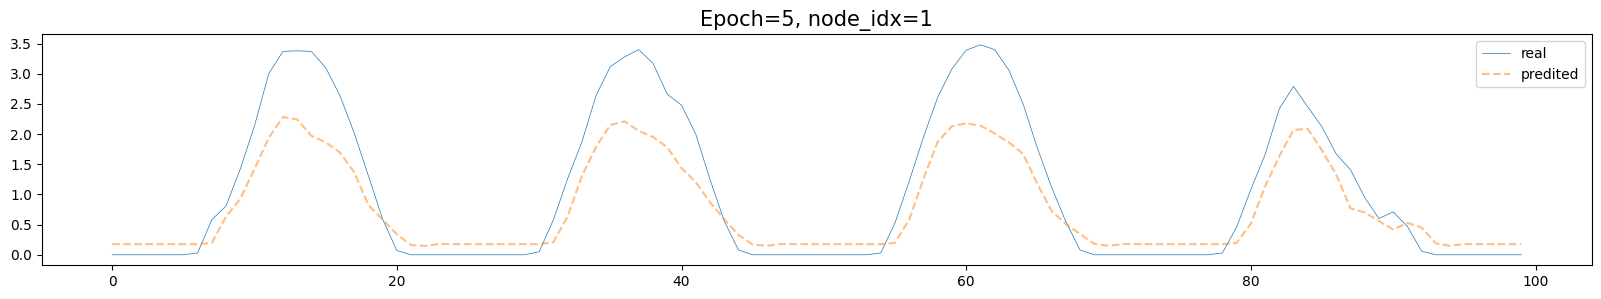

In [15]:
rslt_plot(y, yhat, 100, 1)

`-` yU 학습

In [16]:
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 4 
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 8
lrnr1.model = LR_GCN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(),lr=10/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24)
for e in range(5):    
    lrnr1.learn()

epoch=1  loss=2.60559485436871977965698     
epoch=2  loss=0.3043991419118504798374176   
epoch=3  loss=0.0467868625662874372665024   
epoch=4  loss=0.026934337596473998219612        
epoch=5  loss=0.018896978532592226978985            

In [17]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)

In [18]:
yU_mse = np.mean((yU - yUhat)**2)
yU_mse

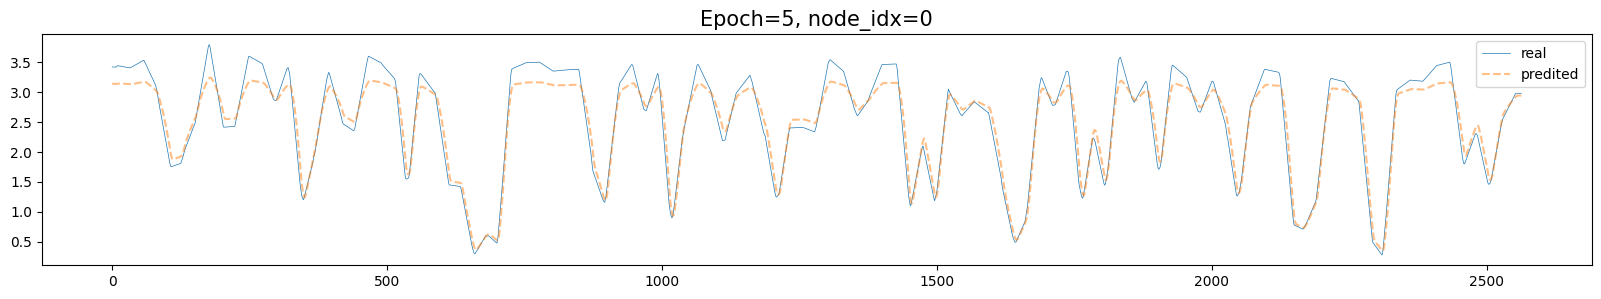

In [28]:
lrnr1.figs[-1]

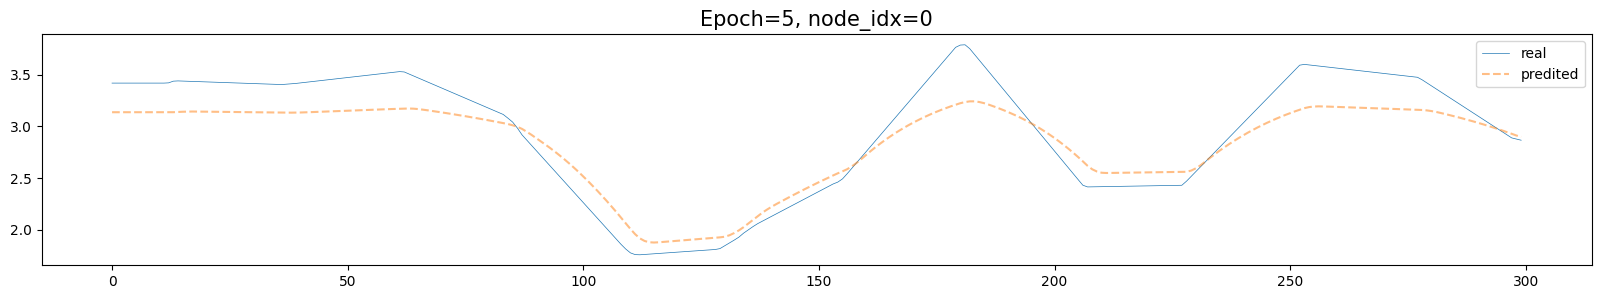

In [20]:
rslt_plot(yU, yUhat, 300, 0)

`-` yP 학습

In [ ]:
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 4 
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 8
lrnr2.model = LR_GCN(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=10/1000)
# step4: learn 
lrnr2.get_batches(batch_size=24)
for e in range(5):    
    lrnr2.learn()

In [29]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0

In [30]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

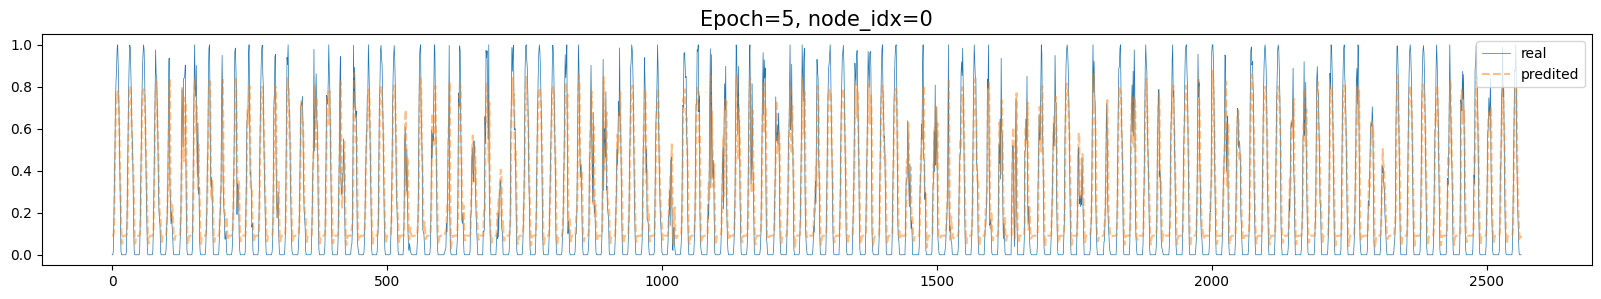

In [31]:
lrnr2.figs[-1]

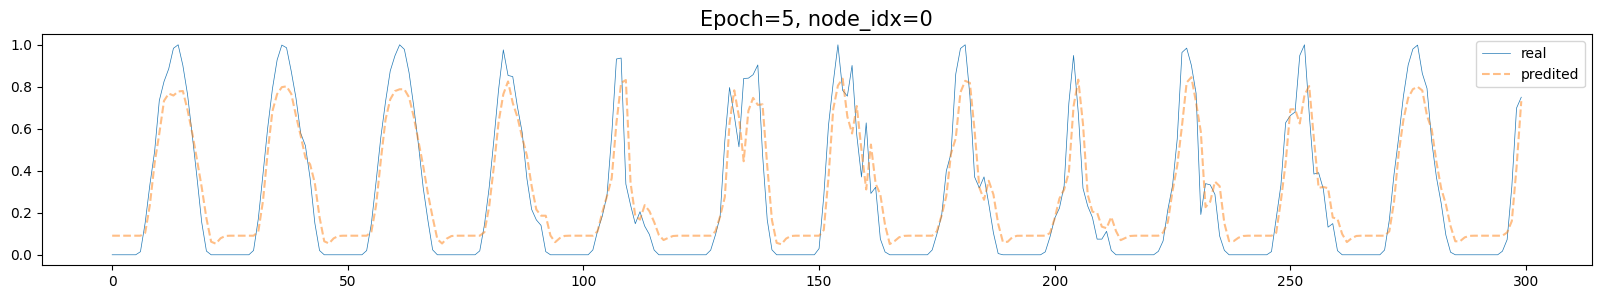

In [32]:
rslt_plot(yP, yPhat, 300, 0)

`-` classic vs. proposed

In [33]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.3336
proposed(mse) 0.1198

In [34]:
# result_columns = ['model','lags', 'filters', 'epoch', 'classic(mse)', 'proposed(mse)']
# rslt_df = pd.DataFrame(columns=result_columns)

In [35]:
new_rslt = pd.DataFrame({'model':['LRGCN'],'lags':[lrnr.lags],'filters':[lrnr.nof_filters],'epoch':[lrnr.epochs],'classic(mse)': [round(classic, 4)], 'proposed(mse)': [round(proposed, 4)],'yU(mse)':[round(yU_mse,4)], 'yP(mse)':[round(yP_mse,4)]})
rslt_df = pd.concat([rslt_df, new_rslt], ignore_index=True)
rslt_df

------------------------------------------------------------------------

# 2023.08.24 수정

**변경내용** : 배치사이즈 및 lag 조정 + Early Stopping

In [10]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric
from torch_geometric_temporal.signal import temporal_signal_split
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal

# torch
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import LRGCN



# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self, patience=1):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self.patience = patience # Early stopping patience
        self.best_loss = float('inf')
        self.early_stop_counter = 0
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio) ####
        self.len_test = self.test_dataset.snapshot_count 
        self.len_tr = self.train_dataset.snapshot_count

    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            mean_loss = np.mean(losses_batch)
            self.losses.append(mean_loss)
            
            print(f'\repoch={self.epochs}\t loss={mean_loss}\n', end='', flush=True)
            
            if mean_loss < self.best_loss - 0.001:
                self.best_loss = mean_loss
                self.early_stop_counter = 0
                self._savefigs()
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("Early stopping triggered")
                    return 
                
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 
    

def rslt_plot(y, yhat, t_end=None, node_idx = None):
    with plt.style.context('default'):
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        node_idx = 0 if node_idx is None else node_idx
        t_end = lrnr.t if t_end is None else t_end
        fig,ax = plt.subplots()
        ax.plot(y[:t_end, node_idx], label='real', lw=0.5)
        ax.plot(yhat[:t_end, node_idx], '--', label='predicted', alpha=0.5)
        ax.set_title(f'Epoch = {lrnr.epochs}, node_idx = {node_idx}', size=15)
        ax.legend()

In [12]:
class LR_GCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(LR_GCN, self).__init__()
        self.recurrent = LRGCN(node_features, filters, 1, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [7]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)



# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## `-` Visualization (classical)

In [18]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = LR_GCN(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=50/1000)
# step4: learn 
lrnr.get_batches(batch_size=128)

lrnr.learn(30)

epoch=1  loss=0.5180307766422629444416046   
epoch=2  loss=0.1530580478720367289897919   
epoch=3  loss=0.107394017744809398326683            
epoch=4  loss=0.0970983221195638265869904       
epoch=5  loss=0.0962828327901661491733551       
Early stopping triggered

In [19]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [20]:
np.mean((y - yhat)[LEN_TR:,:]**2)

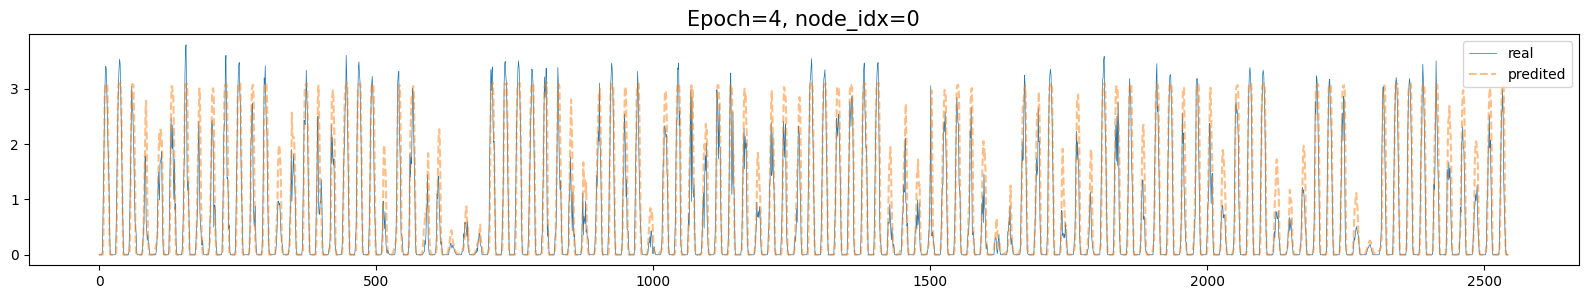

In [21]:
lrnr.figs[-1]

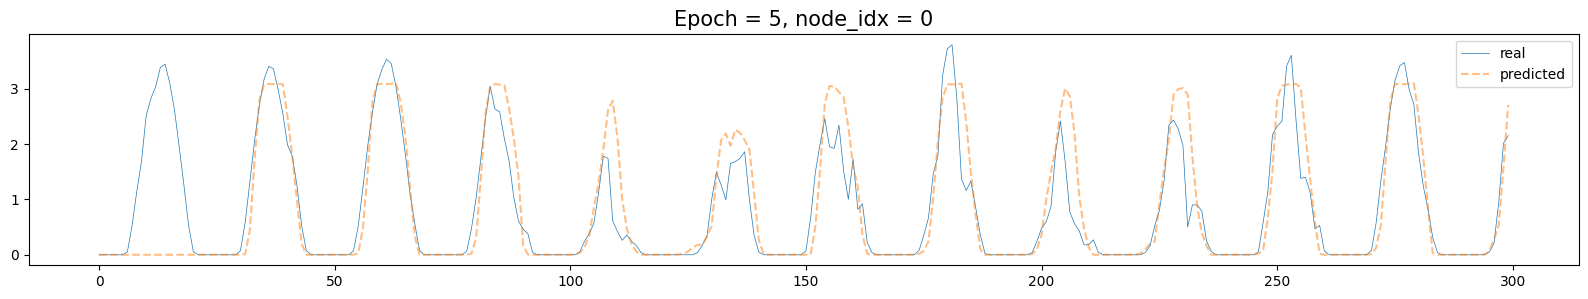

In [22]:
rslt_plot(y, yhat, 300)

## `-` Visualization (proposed)

`-` yUhat

In [24]:
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 24 
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 16
lrnr1.model = LR_GCN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(), lr=50/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24*2)
lrnr1.learn(30)

epoch=1  loss=0.899088938222375108203888    
epoch=2  loss=0.213046082577040028444443        
epoch=3  loss=0.081043854788985361711693        
epoch=4  loss=0.076260061588051710625763        
epoch=5  loss=0.0558862840800091269307404   
epoch=6  loss=0.0499174805834542857701836   
epoch=7  loss=0.049440425972259325354004        
Early stopping triggered

In [25]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)
yU_mse = np.mean((yU - yUhat)[LEN_TR:,:]**2)
yU_mse

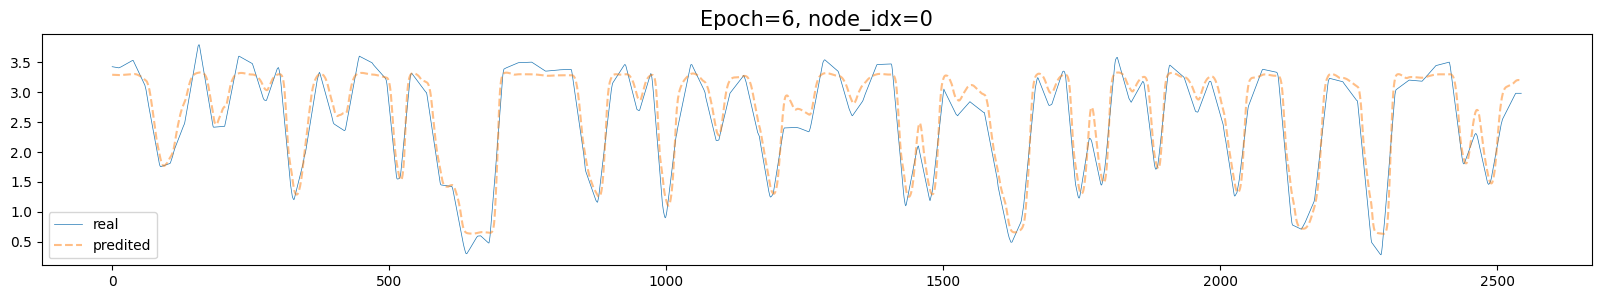

In [26]:
lrnr1.figs[-1]

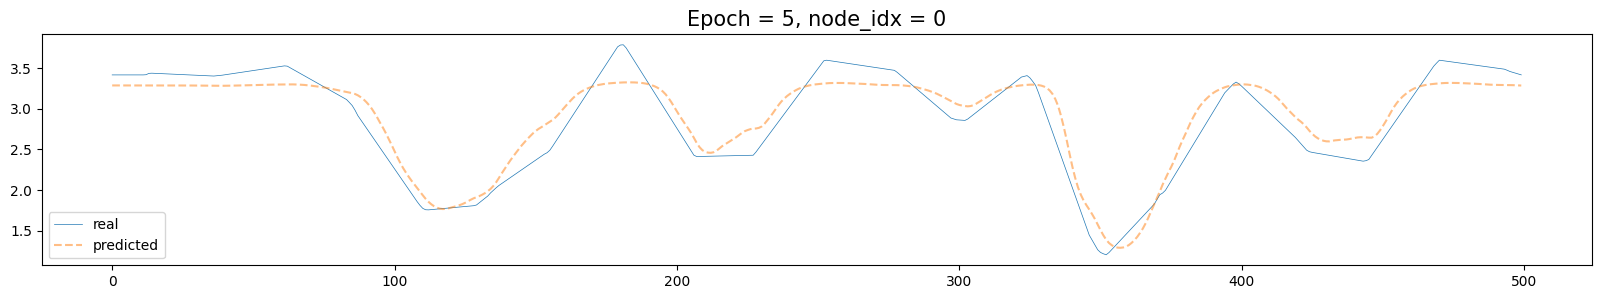

In [28]:
rslt_plot(yU, yUhat, 500)

`-` yPhat

In [29]:
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 24 
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 16
lrnr2.model = LR_GCN(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=50/1000)
# step4: learn 
lrnr2.get_batches(batch_size=128)
lrnr2.learn(30)

epoch=1  loss=0.05061585915973415951156616  
epoch=2  loss=0.0193697164067998532111225       
epoch=3  loss=0.01577108795754611500983715  
epoch=4  loss=0.01411725330399349353586483  
epoch=5  loss=0.0136771446268539885843277       
Early stopping triggered

In [30]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0

In [31]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

## `-` classical vs. proposed

In [32]:
classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))


total_mse(classic): 0.1957
total_mse(proposed): 0.0656


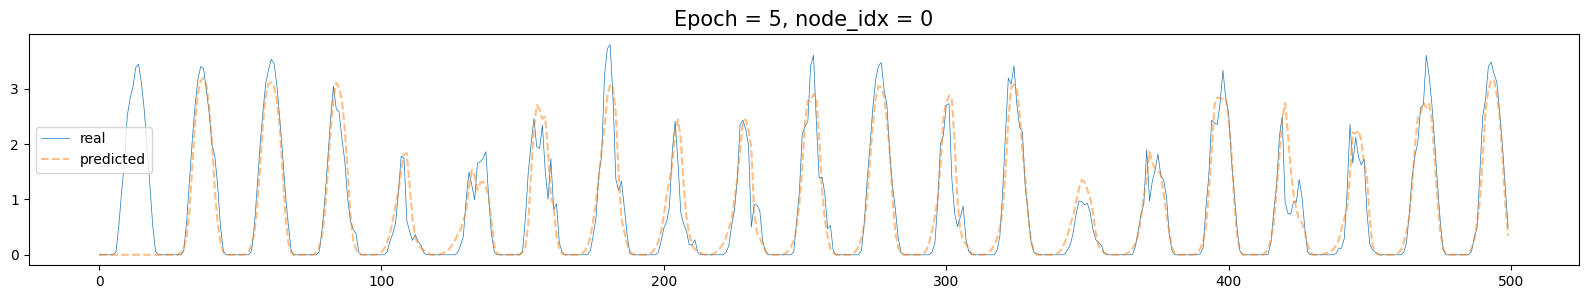

In [34]:
rslt_plot(y, yUhat*yPhat, 500)

## Edit rcgn

In [35]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch, batch_size=128, lr=10/1000):
    # step1: create lrnr object
    lrnr = RGCN_Learner(patience = 1)
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=lr)
    # step4: learn
    lrnr.get_batches(batch_size=batch_size)
    lrnr.learn(epoch)
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags), lrnr.yhat], axis=0)
    return yhat

In [36]:
# hyper params
LAGS = 24
FILTERS = 16
EPOCH = 30

### `-` lr = 50/1000

`-` classical

In [38]:
yhat = rgcn(y, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH, lr=50/1000)
yhat[yhat<0] = 0

epoch=1  loss=0.5005685593932867855815887   
epoch=2  loss=0.1508538499474525559467316       
epoch=3  loss=0.1180117656476795739424896       
epoch=4  loss=0.1057917084544897187072754       
epoch=5  loss=0.0987865049391985401727676       
epoch=6  loss=0.0968614155426621468847656       
epoch=7  loss=0.094729749253019693589592            
epoch=8  loss=0.0944195846095681235803604       
Early stopping triggered

In [39]:
np.mean((y-yhat)[LEN_TR:,:]**2)

`-` proposed method

In [42]:
yUhat = rgcn(yU, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH, batch_size=24*2, lr=10/1000) # lr=10/1000

epoch=1  loss=2.970943493898525728034973    
epoch=2  loss=0.411395311009052217988586    
epoch=3  loss=0.130666070985932784865379        
epoch=4  loss=0.05395103627166083159008         
epoch=5  loss=0.041052009563806446675804        
epoch=6  loss=0.032874785645236805575405        
epoch=7  loss=0.0269592747222199563339233   
epoch=8  loss=0.0244403854878835926001358   
epoch=9  loss=0.02495091796181229670446 2   
Early stopping triggered

In [43]:
np.mean((yU-yUhat)[LEN_TR:,:]**2)

In [44]:
yPhat = rgcn(yP, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH, batch_size=24*2, lr=50/1000) # lr=10/1000
yPhat[yPhat<0] = 0

epoch=1  loss=0.027333574261256433106842            
epoch=2  loss=0.0140574071772916376272125       
epoch=3  loss=0.0125587485503232073304768       
epoch=4  loss=0.0122845359904648266460495       
Early stopping triggered

In [45]:
np.mean((yP-yPhat)[LEN_TR:,:]**2)

`-` result

In [46]:
classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))


total_mse(classic): 0.1672
total_mse(proposed): 0.0774


### `-` lr = 10/1000

In [52]:
yhat_ = rgcn(y, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH, batch_size=128, lr=10/1000)

epoch=1  loss=1.076858127489686764968872        
epoch=2  loss=0.381664900109171876457672        
epoch=3  loss=0.2351503591053187849539948   
epoch=4  loss=0.1678539025597274395292664   
epoch=5  loss=0.1311703720130026317037964   
epoch=6  loss=0.1078610392287373500172806       
epoch=7  loss=0.0989166395738720988057327       
epoch=8  loss=0.0945834931917488665401077       
epoch=9  loss=0.0919490493834018714430618       
epoch=10     loss=0.090472639538347726762466        
epoch=11     loss=0.089593103621155027801437        
Early stopping triggered

In [54]:
np.mean((y-yhat_)[LEN_TR:]**2)

In [48]:
yUhat_ = rgcn(yU, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH, batch_size=24*2, lr=10/1000)

epoch=1  loss=2.18808669129083386061859     
epoch=2  loss=0.429582275276960311406708    
epoch=3  loss=0.2085081766857657431342316   
epoch=4  loss=0.087363073212462856082344        
epoch=5  loss=0.051319763345947172888374        
epoch=6  loss=0.041802904287049934691513        
epoch=7  loss=0.0313631867080233842053223   
epoch=8  loss=0.033500604374810712668476        
Early stopping triggered

In [49]:
np.mean((yU-yUhat_)[LEN_TR:,:]**2)

In [50]:
yPhat_ = rgcn(yP, LR_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH, batch_size= 128, lr=10/1000) # lr=10/1000
yPhat_[yPhat_<0] = 0

epoch=1  loss=0.0562194968806579752903843       
epoch=2  loss=0.02175580029143020524480438  
epoch=3  loss=0.0184880877495743337983799       
epoch=4  loss=0.01699617767008021599326515  
epoch=5  loss=0.01576953270705416842735958  
epoch=6  loss=0.01479046483291313437099457  
Early stopping triggered

In [51]:
np.mean((yP - yPhat_)[LEN_TR:,:]**2)

-   learning rate=0.01일 때 더 좋다

## simul code

In [70]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'lr', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model,lr):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        self.lr = lr
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=24*2, lr=lr)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            self.df.to_csv("./results/test/LR_GCN/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

## `-` Simulation1 (epoch=30, lr=0.01)

In [71]:
s1 = Simulator()

In [ ]:
s1.simulate(
    n_iteration = 5,
    lags = [24],
    filters = [4, 8, 16, 32],
    epoch = [30],
    Model = LR_GCN,
    lr = 0.01
)

epoch=1  loss=1.744711469858884850149536        
epoch=2  loss=1.094015188515186370269775        
epoch=3  loss=0.924199808388948485069275        
epoch=4  loss=0.743981679901480783403015        
epoch=5  loss=0.570867097005248168225098            
epoch=6  loss=0.451134501025080761468506        
epoch=7  loss=0.376361214555799967069397        
epoch=8  loss=0.326620203442871571582031        
epoch=9  loss=0.281684832647442881957245        
epoch=10     loss=0.241289695724844934284363    
epoch=11     loss=0.210898951627314189981842    
epoch=12     loss=0.192975897341966632213135    
epoch=13     loss=0.179669109173119071394348    
epoch=14     loss=0.168268930632621056450043    
epoch=15     loss=0.157667141873389482194977    
epoch=16     loss=0.148947706446051677494812    
epoch=17     loss=0.142176181543618449141693    
epoch=18     loss=0.13623870955780149654419     
epoch=19     loss=0.130999955814331772736664    
epoch=20     loss=0.126474018674343823779984    
epoch=21     los

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [75]:
import os
fnames = ['./results/test/LR_GCN/'+l for l in os.listdir('./results/test/LR_GCN/') if l[0] != '.'][1:]
fnames 

In [76]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

### Simul1 result (lag=24, epoch=30, lr=0.01)

In [77]:
df.groupby(by=['method','nof_filters']).agg({'mse':[np.mean, np.std]}) # learning rate = 10/1000

## `-` Simulation2 (epoch=10, lr=0.01)

In [79]:
s2 = Simulator()

In [ ]:
s2.simulate(
    n_iteration = 5,
    lags = [24],
    filters = [4, 8, 16, 32],
    epoch = [10],
    Model = LR_GCN,
    lr = 0.01
)

epoch=1  loss=1.9098109528422356821167  5       
epoch=2  loss=1.243587650358677333450317        
epoch=3  loss=1.028363984078168908442688        
epoch=4  loss=0.921178743243217508215332        
epoch=5  loss=0.746132766827940947175598        
epoch=6  loss=0.600848639383912198872375        
epoch=7  loss=0.511252038180828130018616        
epoch=8  loss=0.4492161814123392620025635   
epoch=9  loss=0.408073071390390412736511        
epoch=10     loss=0.37208142224699264565735     
method:classic lag:24 filters:4 epoch:10 is done
epoch=1  loss=0.524972614832222566598511        
epoch=2  loss=0.2319217184558510838974762   
epoch=3  loss=0.1618689922615885704301453   
epoch=4  loss=0.1313400589860975712731934   
epoch=5  loss=0.1196412588469684174601746   
epoch=6  loss=0.1115127117373049348600769   
epoch=7  loss=0.1060463041067123439985657   
epoch=8  loss=0.1021196991205215506695557   
epoch=9  loss=0.0989439110271632702684402   
epoch=10     loss=0.096478810068219998081589    
method:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [81]:
import os
fnames = ['./results/test/LR_GCN/'+l for l in os.listdir('./results/test/LR_GCN/') if l[0] != '.'][1:]
fnames 

In [82]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

In [83]:
df2 = df[df['epoch']==10]

### Simul2 result (lag=24, epoch=10, lr=0.01)

In [84]:
df2.groupby(by=['method','nof_filters']).agg({'mse':[np.mean, np.std]}) # learning rate = 10/1000